# Lab 8: Spectral Factorizations
Gizem Tabak (tabak2)

In [11]:
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import IPython
from matplotlib import mlab as mlab
from os.path import join

plt.rcParams["figure.figsize"] = (12, 6)

## Part 1: Learning Spectral Components

In [2]:
fs_drum, s_drum = wv.read('data/80s-hi.wav')
s_drum = s_drum/max(abs(s_drum))
print('Drum roll')
IPython.display.display(IPython.display.Audio(s_drum, rate=fs_drum))

Drum roll


In [3]:
def stft( input_sound, fs, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        t_axis = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        f_axis = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # # Make zero elements equal to the smallest value to avoid log(0) for plotting
        # min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        # stft_output[stft_output == 0] = min_nonzero
# 
        plt.pcolormesh(t_axis, f_axis, (np.abs(stft_output)**0.4), cmap='gist_gray_r')
        plt.xlabel('Time (sec)')
        plt.ylabel('Freq (Hz)')
        plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
        plt.grid(alpha=0.5)
        plt.colorbar()
        plt.show()

        return stft_output, t_axis, f_axis
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

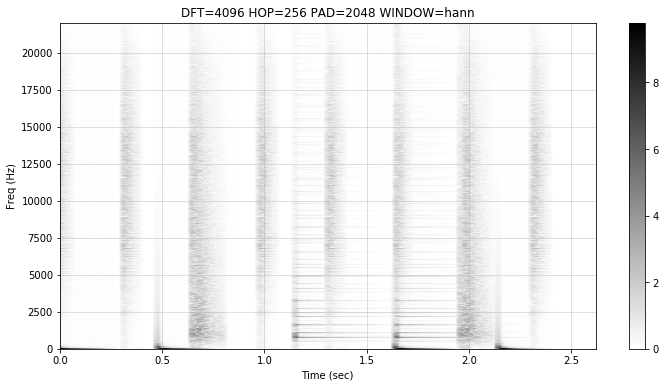

In [12]:
dft_size = 4096
hop_size = 256
zero_pad = dft_size//2
window = 'hann'
F_drum, t, f = stft(s_drum, fs_drum, dft_size, hop_size, zero_pad, window)

In [5]:
M, N = np.shape(F_drum)
K = 4

### Iterative Matrix Factorization
$\textbf{V} = \dfrac{|\textbf{F}|}{\textbf{W}\textbf{H}+\epsilon}$

$\textbf{H} = \textbf{H} \odot \left[\textbf{W}^T\textbf{V}\right]$

$\textbf{W} = \textbf{W} \odot \left[\textbf{V}^T\textbf{H}\right]$

$\textbf{W} = \dfrac{\textbf{W}}{\left[||\textbf{w}_1||_1 \dots ||\textbf{w}_K||_1\right]_M}$

where $\textbf{w}_i$ are the column vectors of $\textbf{W}$, $||\cdot||_1$ denots the sum of vector elements and $\left[\cdot\right]_M$ denotes row replication.


In [152]:
def matrix_factorization(F, M, N, K):
    W = rnd.uniform(10., 11., (M, K))
    H = rnd.uniform(10., 11., (K, N))
    eps = 1e-10
    for i in range(200):
        V = np.abs(F)/(np.dot(W, H) + eps)
        H = H*np.dot(W.T, V)
        W = W*np.dot(V, H.T)
        W = W / np.sum(W, axis=0, keepdims=True)
    return W, H
W,H = matrix_factorization(F_drum, M, N, K)

When I try to separate different components, I observed that it is harder to separate the components that have more common frequency content and similar timing, which is expected. The ones represented as Component 1 and Component 3 in the plots below have quite a bit common frequency content around 1 KHz, while Component 2 and Component 3 share a little bit of common frequency content at very low frequencies (probably around a few Hz). Component 4, on the other hand, does not seem to share that much frequency content with others. As a result of the shared spectral content, the separation of components 1, 2 and 3 are not perfect. In the timing plots under the spectrogram, we can see a lot of similar timing in Component 3 with Component 1 and a little bit with Component 2. It is interesting to note that Component 3's effect on Components 1 and 2 is not as much pronounced in the timing plots. 

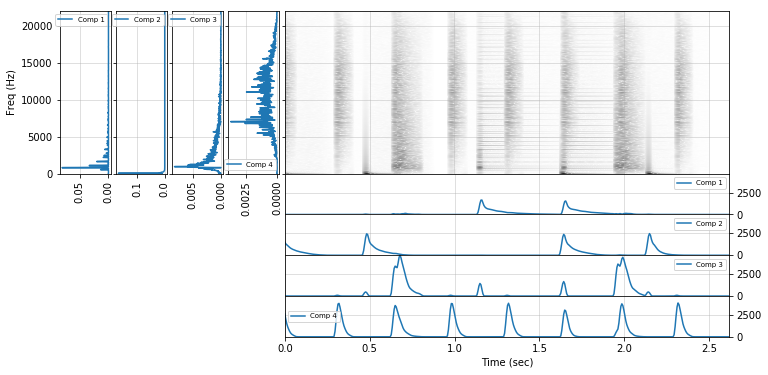

In [106]:
# fig = plt.figure(figsize=(16,12))
ax1_0 = plt.subplot2grid((8, 12), (0, 0), rowspan=4)
ax1_0.invert_xaxis()
# ax1_0.set_xlim([np.max(W), 0])
ax1_0.set_ylim([f[0], f[-1]])
plt.plot(W[:,0], f)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.5)
plt.legend(['Comp 1'], fontsize='x-small')
plt.ylabel('Freq (Hz)')

ax1_1 = plt.subplot2grid((8, 12), (0, 1), rowspan=4)
ax1_1.invert_xaxis()
# ax1_1.set_xlim([np.max(W), 0])
ax1_1.set_ylim([f[0], f[-1]])
plt.plot(W[:,1], f)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.5)
plt.legend(['Comp 2'], fontsize='x-small')
plt.setp(ax1_1.get_yticklabels(), visible=False)

ax1_2 = plt.subplot2grid((8, 12), (0, 2), rowspan=4)
ax1_2.invert_xaxis()
# ax1_2.set_xlim([np.max(W), 0])
ax1_2.set_ylim([f[0], f[-1]])
plt.plot(W[:,2], f)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.5)
plt.legend(['Comp 3'], fontsize='x-small')
plt.setp(ax1_2.get_yticklabels(), visible=False)

ax1_3 = plt.subplot2grid((8, 12), (0, 3), rowspan=4)
ax1_3.invert_xaxis()
# ax1_3.set_xlim([np.max(W), 0])
ax1_3.set_ylim([f[0], f[-1]])
plt.plot(W[:,3], f)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.5)
plt.legend(['Comp 4'], fontsize='x-small')
plt.setp(ax1_3.get_yticklabels(), visible=False)

ax2 = plt.subplot2grid((8, 12), (0, 4), rowspan=4, colspan=8)
plt.pcolormesh(t, f, (np.abs(F_drum)**0.3), cmap='gray_r')
plt.grid(alpha=0.5)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

ax2_0 = plt.subplot2grid((8, 12), (4, 4), colspan=8)
ax2_0.set_xlim([t[0]-1e-3, t[-1]])
ax2_0.set_ylim([0, (np.max(H))])
ax2_0.yaxis.tick_right()
plt.plot(t, H[0,:])
plt.grid(alpha=0.5)
plt.legend(['Comp 1'], fontsize='x-small')
plt.setp(ax2_0.get_xticklabels(), visible=False)

ax2_1 = plt.subplot2grid((8, 12), (5, 4), colspan=8)
ax2_1.set_xlim([t[0]-1e-3, t[-1]])
ax2_1.set_ylim([0, np.max(H)])
ax2_1.yaxis.tick_right()
plt.plot(t, H[1,:])
plt.grid(alpha=0.5)
plt.legend(['Comp 2'], fontsize='x-small')
plt.setp(ax2_1.get_xticklabels(), visible=False)

ax2_2 = plt.subplot2grid((8, 12), (6, 4), colspan=8)
ax2_2.set_xlim([t[0]-1e-3, t[-1]])
ax2_2.set_ylim([0, np.max(H)])
ax2_2.yaxis.tick_right()
plt.plot(t, H[2,:])
plt.grid(alpha=0.5)
plt.legend(['Comp 3'], fontsize='x-small')
plt.setp(ax2_2.get_xticklabels(), visible=False)

ax2_3 = plt.subplot2grid((8, 12), (7, 4), colspan=8)
ax2_3.set_xlim([t[0]-1e-3, t[-1]])
ax2_3.set_ylim([0, np.max(H)])
ax2_3.yaxis.tick_right()
plt.plot(t, H[3,:])
plt.grid(alpha=0.5)
plt.legend(['Comp 4'], fontsize='x-small')
plt.xlabel('Time (sec)')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()

In order to identify the sounds of individual instruments and compare them to the recunstructions below, I tried to isolate the sections of the original sound clip during which only a single instrument is playing. It was relatively easy to isolate cymbal and bass drum sections since there are parts of the clip where most of their sound can be heard without other instruments. However, it was harder to catch the synthetic bell fully, and it was not possible to iseolate the snare drum since it had similar timing with the cymbal and did not occur by itself during the clip.

The ones with better ears that are familiar with those instruments might identify the components easily by just looking at the frequency contents or listening to the beats in the original sound. However, I had a hard time doing that, especially with components 3 and 4. Hence, this isolation helped me identify the components as instruments. The component-instrument matchings turned out to be 
- Component 1 - Synthetic bell 
- Component 2 - Bass drum 
- Component 3 - Snare drum 
- Component 4 - Synthetic Bell 


This also helped me determine if those common peaks in timing plots are "leakings" from other components or if they are real, smaller beats from the same component. For example, Component 1 and 3 share a similar peak around 1.2s in the timing plot. When I listen to the original signal at that time (3rd clip below), I could only hear the synthetic bell sound. This means the smaller peaks in Component 3 is leakings from Component 1 and vice versa.

In [116]:
print('Cymbal')
IPython.display.display(IPython.display.Audio(s_drum[int(0.25*fs_drum):int(0.40*fs_drum)], rate=fs_drum))

Cymbal


In [129]:
print('Bass drum')
IPython.display.display(IPython.display.Audio(s_drum[int(0.42*fs_drum):int(0.63*fs_drum)], rate=fs_drum))

Bass drum


In [133]:
print('Synthetic bell')
IPython.display.display(IPython.display.Audio(s_drum[int((1.1)*fs_drum):int(1.33*fs_drum)], rate=fs_drum))

Synthetic bell


In [137]:
print('Snare drum')
IPython.display.display(IPython.display.Audio(s_drum[int((0.6)*fs_drum):int(0.8*fs_drum)], rate=fs_drum))

Snare drum


When I reconstruct each component, I observed the leakings as expected previously. Although they are mostly separated, the reconstructed Component 3, which corresponds to the snare drum, had a lot of extra beats resulted from the timings of the bass drum and synthetic bell. Similarly, synthetic bell also had some extra, smaller beats but the loudest, fuller beats were at their original timing.

One interesting observation is the frerquency content of the cymbal. Since it shares its lower spectral content around 1kHz with snare drum and cymbal, some of the energy in these frequencies leaks to those components, and the reconstructed cymbal sounds hollower than the original one.

Original


Component  1


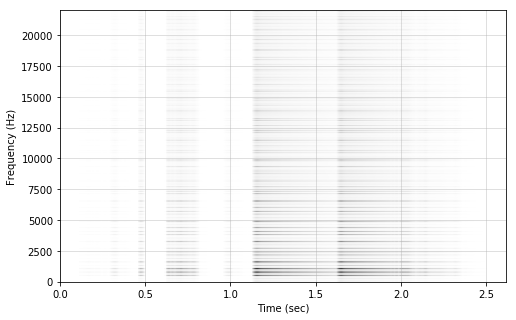

Component  2


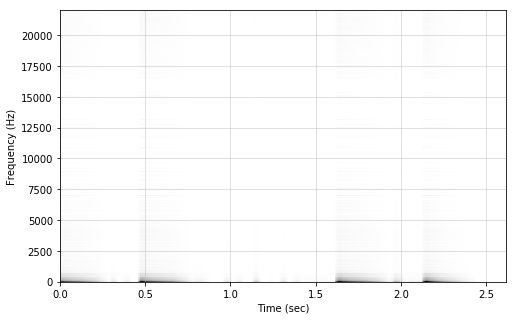

Component  3


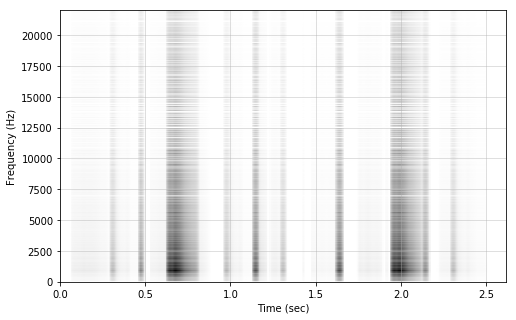

Component  4


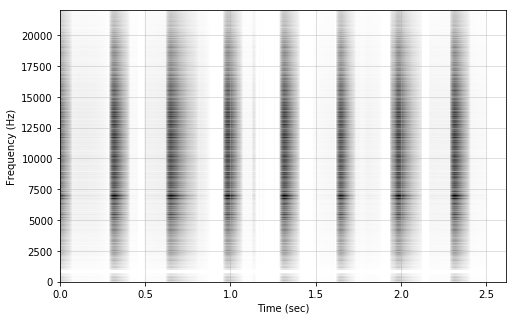

In [107]:
print('Original')
IPython.display.display(IPython.display.Audio(s_drum[int(0.25*fs_drum):int(0.40*fs_drum)], rate=fs_drum))
    
for i in range(K):
    F_comp = np.outer(W[:,i], H[i,:])
    s_comp = stft(F_comp*np.exp(1j*np.angle(F_drum)), fs_drum, dft_size, hop_size, zero_pad, window)
    print('Component ',i+1)
    IPython.display.display(IPython.display.Audio(s_comp, rate=fs_drum))
    plt.figure(figsize=(8,5))
    plt.pcolormesh(t, f, (np.abs(F_comp)**0.3), cmap='gray_r')
    plt.grid(alpha=0.5)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

## Part 2: Training dictionaries for source separation

In [155]:
fs_speech, s_speech = wv.read('data/speaker.wav')
s_speech = s_speech/max(abs(s_speech))
fs_chimes,  s_chimes = wv.read('data/chimes.wav')
s_chimes = s_chimes/max(abs(s_chimes))
print('Speaker')
IPython.display.display(IPython.display.Audio(s_speech, rate=fs_speech))
print('Chimes')
IPython.display.display(IPython.display.Audio(s_chimes, rate=fs_chimes))

Speaker


Chimes


The first sentence seems to last about 3.5 seconds.

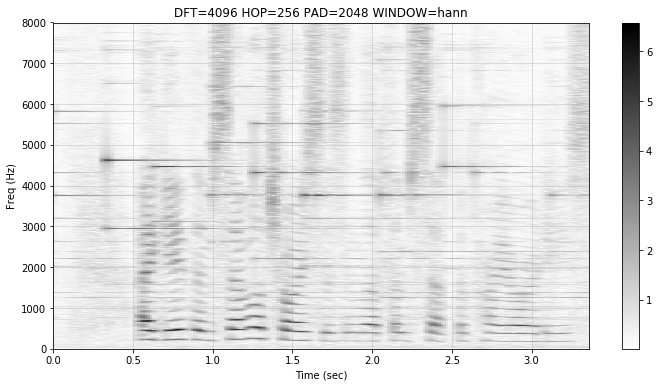

In [179]:
IPython.display.display(IPython.display.Audio(s_speech[:int(3.5*fs_speech)], rate=fs_speech))
s_mix = s_speech[:int(3.5*fs_speech)] + s_chimes[:int(3.5*fs_speech)]
F_mix, t_mix, f_mix = stft(s_mix, fs_speech, dft_size, hop_size, zero_pad, window)

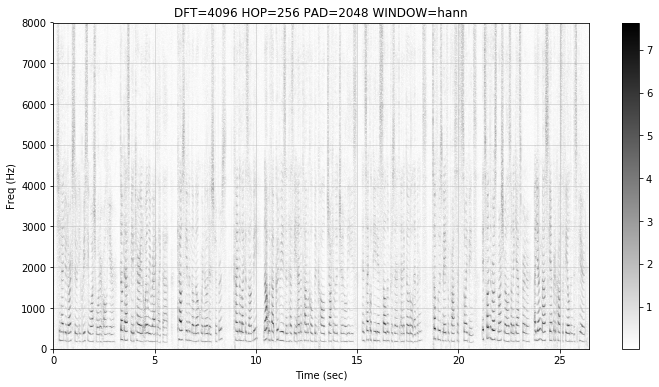

In [159]:
s_speech_rest = s_speech[int(3.5*fs_speech):]
F_speech, t_speech, f_speech = stft(s_speech_rest, fs_speech, dft_size, hop_size, zero_pad, window)
W_speech, H_speech = matrix_factorization(F_speech, M=np.size(F_speech,0), N=np.size(F_speech,1), K=40)

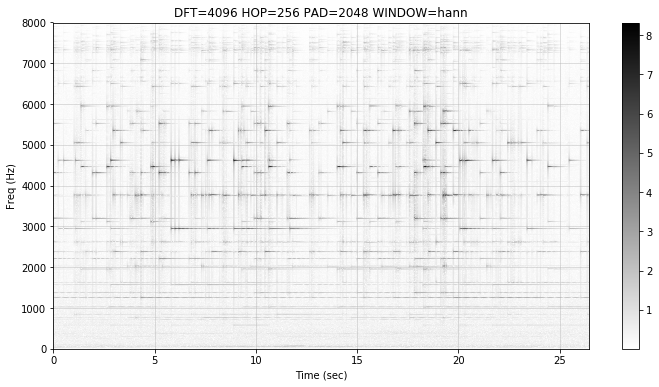

In [160]:
s_chimes_rest = s_chimes[int(3.5*fs_speech):]
F_chimes, t_chimes, f_chimes = stft(s_chimes_rest, fs_chimes, dft_size, hop_size, zero_pad, window)
W_chimes, H_chimes = matrix_factorization(F_chimes, M=np.size(F_chimes,0), N=np.size(F_chimes,1), K=40)

As it can be seen from the plots below, the dictionary of the speech signal has many features with comb-like structures and higher power at lower, busier frequencies, and has fewer features with lower power that spans a wider range at higher frequencies. Unlike speech, the dictionary of the chimes has more impulse-like features at different, narrower frequencies.

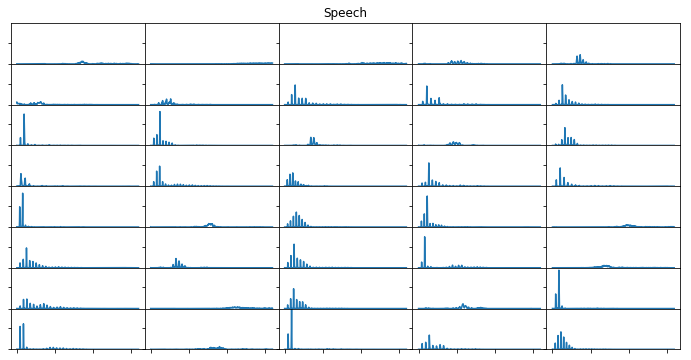

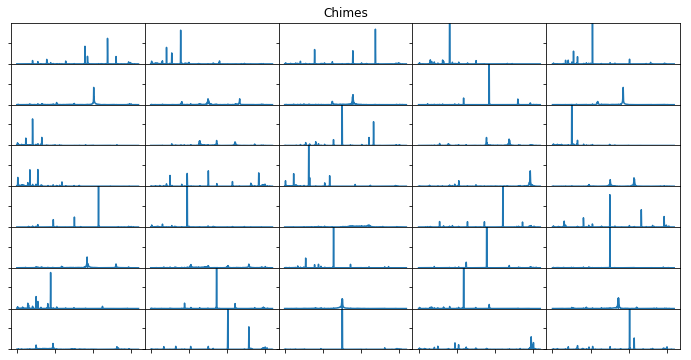

In [170]:
for i in range(40):
    ax = plt.subplot2grid((8, 5), (i//5, i%5))
    plt.plot(f_speech, W_speech[:,i])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.ylim([0,np.max(W_speech)])
    if i == 2: plt.title('Speech')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

for i in range(40):
    ax = plt.subplot2grid((8, 5), (i//5, i%5))
    plt.plot(f_chimes, W_chimes[:,i])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.ylim([0,np.max(W_speech)])
    if i == 2: plt.title('Chimes')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
    

In [181]:
W_conc = np.concatenate([W_speech, W_chimes], axis=1)
H_conc = rnd.uniform(10., 11., (80, np.size(F_mix,1)))
eps = 1e-10
for i in range(200):
    V_conc = np.abs(F_mix)/(np.dot(W_conc, H_conc) + eps)
    H_conc = H_conc*np.dot(W_conc.T, V_conc)
    # W = W*np.dot(V, H.T)
    # W = W / np.sum(W, axis=0, keepdims=True)

The reconstructed signals sound satisfactorily separated. In the spectrograms, both signals seem to be smeared over the frequency axis, while timings are the same with the original clips. Due to the smearing, the reconstructed speech signal does not sound as crisp and clear as the original one, although still perfectly understandable. The chimes in the reconstructed clip sound a little bit wobbly, like there is a slight modulation feeling in the sound.

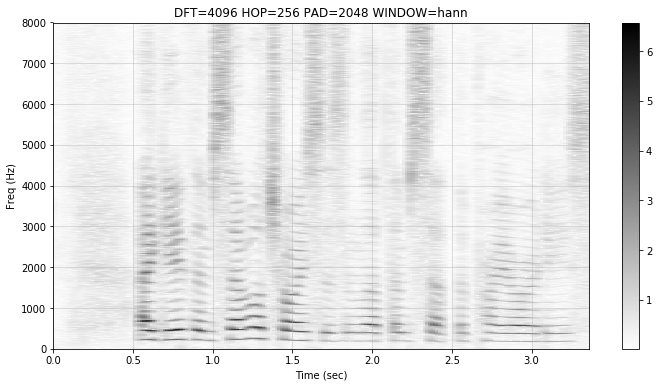

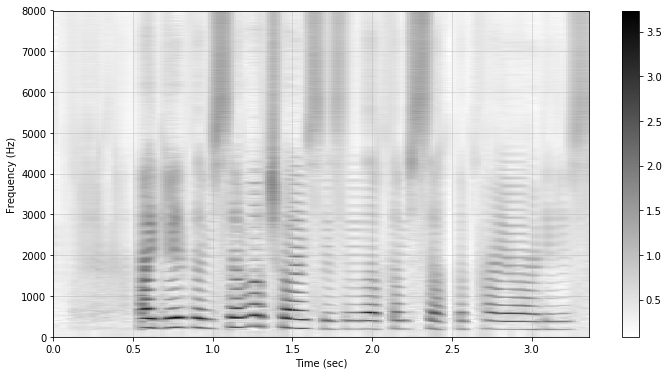

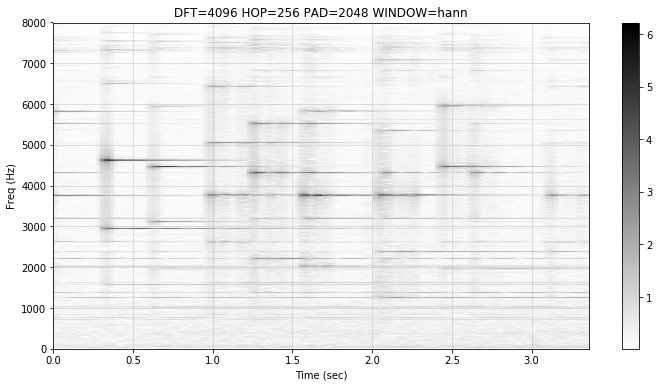

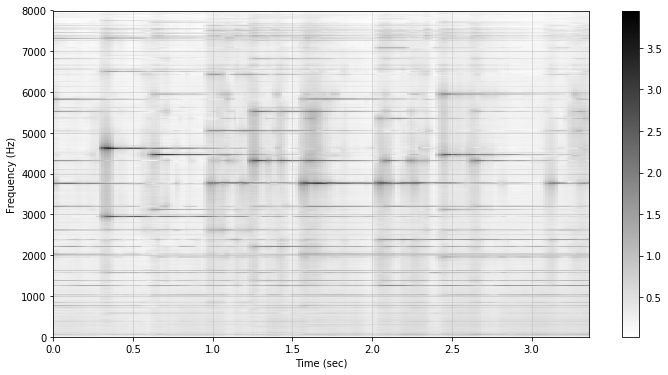

Original Speech


Separated Speech


Original Chimes


Separated Chimes


In [194]:
H_speech = H_conc[:40,:]
H_chimes = H_conc[40:,:]
F_mix_speech = np.dot(W_speech, H_speech)*np.exp(1j*np.angle(F_mix))
F_mix_chimes = np.dot(W_chimes, H_chimes)*np.exp(1j*np.angle(F_mix))

ss,tt,ff  = stft(s_speech[:int(3.5*fs_speech)], fs_speech, dft_size, hop_size, zero_pad, window)
plt.figure()
plt.pcolormesh(t_mix, f_mix, (np.abs(F_mix_speech)**0.3), cmap='gray_r')
plt.grid(alpha=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

ss,tt,ff  = stft(s_chimes[:int(3.5*fs_speech)], fs_chimes, dft_size, hop_size, zero_pad, window)
plt.figure()
plt.pcolormesh(t_mix, f_mix, (np.abs(F_mix_chimes)**0.3), cmap='gray_r')
plt.grid(alpha=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

s_mix_speech = stft(F_mix_speech, fs_speech, dft_size, hop_size, zero_pad, window)
s_mix_chimes = stft(F_mix_chimes, fs_chimes, dft_size, hop_size, zero_pad, window)

print('Original Speech')
IPython.display.display(IPython.display.Audio(s_speech[:int(3.5*fs_speech)], rate=fs_speech))
print('Separated Speech')
IPython.display.display(IPython.display.Audio(s_mix_speech, rate=fs_speech))

print('Original Chimes')
IPython.display.display(IPython.display.Audio(s_chimes[:int(3.5*fs_speech)], rate=fs_speech))
print('Separated Chimes')
IPython.display.display(IPython.display.Audio(s_mix_chimes, rate=fs_chimes))
